In [114]:
# Basic Template
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from tqdm.auto import trange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
from context import voxelproj

In [116]:
SX = 9
SY = 10
H = 1
PX = SX+SY
n_angles = 111
y_shape = {0: (n_angles, PX, H), 2: (H, n_angles, PX)}
x_shape = {0: (SY, SX, H), 2: (H, SY, SX)}
dtype = 'float32'
angles = np.linspace(0, np.pi, n_angles, endpoint=True).astype(np.float32)


def profile_z0(y):
    return np.sum(np.sum(y, -1), -1)


def profile_z2(y):
    return np.sum(np.sum(y, -1), 0) 
    
def phantom_z0(xi, yi):
    x = np.zeros(x_shape[0]).astype(dtype)
    x[yi, xi, :] = 1
    return x


def phantom_z2(xi, yi):
    x = np.zeros(x_shape[2]).astype(dtype)
    x[:, yi, xi] = 1
    return x    

In [117]:
profiles_0 = {}
for xi in trange(SX):
    for yi in range(SY):
        y = voxelproj.forward(phantom_z0(xi, yi), angles, y=y_shape[0],z_order = 0)
        y_sum = profile_z0(y)
        profiles_0[(xi,yi)]=y_sum


  0%|          | 0/9 [00:00<?, ?it/s]

In [118]:
import tomosipo as ts
vg = ts.volume(shape=x_shape[2])
pg = ts.parallel(angles=angles, shape=y_shape[2][::2])
A = ts.operator(vg, pg)

profiles_ts = {}
for xi in trange(SX):
    for yi in range(SY):
        y_ts = A(phantom_z2(xi, yi))
        profiles_ts[(xi,yi)]=profile_z2(y_ts)

  0%|          | 0/9 [00:00<?, ?it/s]

In [120]:
from leapctype import tomographicModels
leapct = tomographicModels()
angles_deg = np.degrees(angles)

y_shape_leap = (n_angles, H, PX)
leapct.set_parallelbeam(
    numAngles=len(angles_deg),
    numRows=H,
    numCols=PX,
    pixelHeight=1,
    pixelWidth=1,
    centerRow=0.5 * (H - 1),
    centerCol=0.5 * (PX - 1),
    phis=angles_deg,
)
profiles_leap = {}

for xi in range(SX):
    for yi in range(SY):
        leapct.set_volume(*x_shape[0], voxelWidth=1, voxelHeight=1)
        y = np.zeros(y_shape_leap, dtype="float32")
        leapct.project(y, phantom_z0(xi, yi))
        profiles_leap[(xi,yi)]=profile_z0(y)

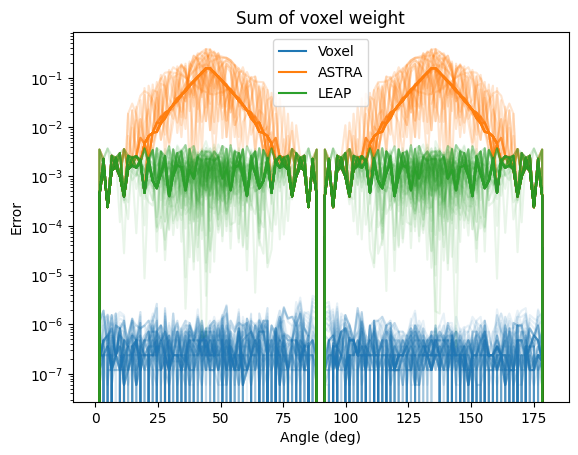

In [ ]:
for k,v in profiles_0.items():
    plt.semilogy(np.degrees(angles),np.abs(v-H),'C0',alpha = 0.1)
plt.semilogy(np.degrees(angles[:1]),np.abs(v-H)[:1],'C0', label = 'Voxel')

for k,v in profiles_ts.items():
    plt.plot(np.degrees(angles),np.abs(v-H),'C1',alpha = 0.1)
plt.semilogy(np.degrees(angles)[:1],np.abs(v-H)[:1],'C1', label = 'ASTRA')

for k,v in profiles_leap.items():
    plt.plot(np.degrees(angles),np.abs(v-H),'C2',alpha = 0.1)
plt.semilogy(np.degrees(angles)[:1],np.abs(v-H)[:1],'C2', label = 'LEAP')

    
plt.xlabel('Angle (deg)')
plt.ylabel('Error')
plt.title('Sum of voxel weight')
plt.legend()
plt.savefig('Voxel_weight', bbox_inches = 'tight')


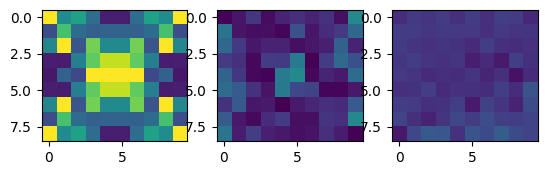

In [122]:
error_vox = np.zeros((SX,SY))
error_ts = np.zeros((SX,SY))
error_leap = np.zeros((SX,SY))

for k,v in profiles_0.items():
    error_vox[k]=np.abs(np.mean(v.astype('float64'))-1)
for k,v in profiles_leap.items():
    error_leap[k]=np.abs(np.mean(v.astype('float64'))-1)
for k,v in profiles_ts.items():
    error_ts[k]=np.abs(np.mean(v.astype('float64'))-1)

f, (ax1,ax2,ax3)= plt.subplots(ncols = 3)
ax1.imshow(error_ts, clim = (0,2e-2))
ax2.imshow(error_leap, clim = (0,1e-3))
ax3.imshow(error_vox, clim = (0,1e-6))

